In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from pathlib import Path
import numpy as np
import torch
from PIL import Image
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.field_components.field_heads import FieldHeadNames

In [3]:
config_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/config.yml"
config_path = Path("/", *config_path.split("/"))
checkpoint_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models"

In [4]:
_, pipeline, _, _ = eval_setup(config_path, eval_num_rays_per_chunk=None, test_mode="inference", checkpoint_path=checkpoint_path)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models/step-000999999.ckp
t

In [5]:
pipeline.datamanager.setup_train()

Setting up training dataset...

Caching all 120 images.

Output()

In [12]:
current_index = torch.tensor(119)
camera_transforms = pipeline.datamanager.train_camera_optimizer(current_index.unsqueeze(dim=0))
current_camera = pipeline.datamanager.train_dataparser_outputs.cameras[current_index].to('cuda')
modified_camera = Cameras(
    fx=torch.tensor([[548.9938],[548.9938]]).to('cuda'),
    fy=torch.tensor([[548.9938],[548.9938]]).to('cuda'),
    cx=torch.tensor(256.).to('cuda'),
    cy=torch.tensor(256.).to('cuda'),
    camera_to_worlds=current_camera.camera_to_worlds,
    camera_type=current_camera.camera_type,
    times=current_camera.times
)
current_ray_bundle = modified_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)

In [13]:
with torch.no_grad():
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(current_ray_bundle)

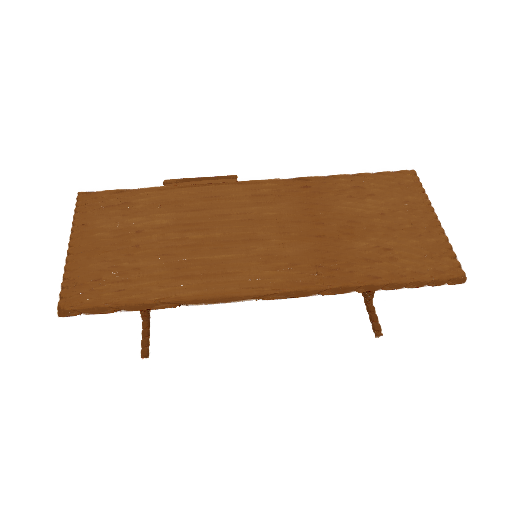

In [14]:
image = (outputs['rgb_coarse'].cpu().numpy() * 255).astype(np.uint8)
image = Image.fromarray(image)
image


In [15]:
# num_rays_per_chunk = pipeline.model.config.eval_num_rays_per_chunk
# image_height, image_width = current_ray_bundle.origins.shape[:2]
# num_rays = len(current_ray_bundle)
# # outputs_lists = defaultdict(list)
# rgb_fine_outputs = []
# with torch.no_grad():
#     for i in range(0, num_rays, num_rays_per_chunk):
#         start_idx = i
#         end_idx = i + num_rays_per_chunk
#         ray_bundle = current_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
#         if pipeline.model.collider is not None:
#             ray_bundle = pipeline.model.collider(ray_bundle)
#         if pipeline.model.field is None:
#                 raise ValueError("populate_fields() must be called before get_outputs")
#         ray_samples_uniform = pipeline.model.sampler_uniform(ray_bundle)
#         field_outputs_coarse = pipeline.model.field.forward(ray_samples_uniform)
#         weights_coarse = ray_samples_uniform.get_weights(field_outputs_coarse[FieldHeadNames.DENSITY])
#         rgb_coarse = pipeline.model.renderer_rgb(rgb=field_outputs_coarse[FieldHeadNames.RGB], weights=weights_coarse)
#         ray_samples_pdf = pipeline.model.sampler_pdf(ray_bundle, ray_samples_uniform, weights_coarse)
#         field_outputs_fine = pipeline.model.field.forward(ray_samples_pdf)
#         weights_fine = ray_samples_pdf.get_weights(field_outputs_fine[FieldHeadNames.DENSITY])
#         rgb_fine = pipeline.model.renderer_rgb(
#             rgb=field_outputs_fine[FieldHeadNames.RGB],
#             weights=weights_fine,
#         )
#         rgb_fine_outputs.append(rgb_fine)
#     rgb_fine = torch.cat(rgb_fine_outputs).view(image_height, image_width, -1)

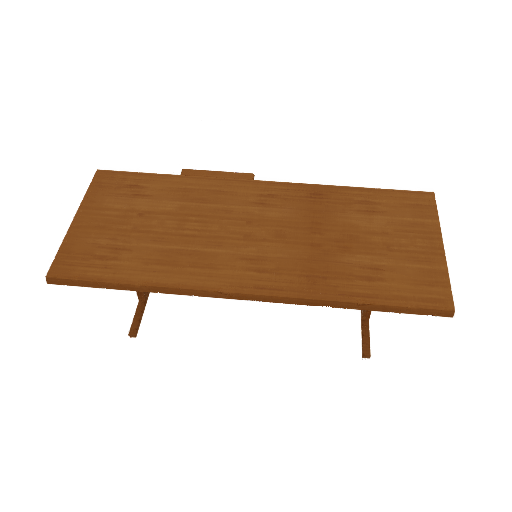

In [11]:
# image = (rgb_fine.cpu().numpy() * 255).astype(np.uint8)
# image = Image.fromarray(image)
# image